<a href="https://colab.research.google.com/github/bythyag/machine-learning-projects/blob/main/PCA_Study_20_Newsgroups_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from time import time

In [3]:
# Load a subset of the 20 newsgroups dataset
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
print(f"Loading newsgroups data for categories: {categories}")

# Fetch the dataset
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories,
                                    remove=('headers', 'footers', 'quotes'))

print(f"Number of documents: {len(newsgroups_train.data)}")
print(f"Number of categories: {len(newsgroups_train.target_names)}")
print(f"Category names: {newsgroups_train.target_names}")

Loading newsgroups data for categories: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
Number of documents: 2257
Number of categories: 4
Category names: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


In [4]:
# Convert text documents to TF-IDF features
# This creates a matrix where each row is a document and each column is a word
print("Converting text to TF-IDF features...")
start_time = time()

# Create TF-IDF vectorizer
# max_features limits vocabulary size, min_df removes very rare words
vectorizer = TfidfVectorizer(max_features=5000,  # Limit to 5000 most common words
                           min_df=2,              # Word must appear in at least 2 documents
                           max_df=0.8,            # Ignore words that appear in >80% of documents
                           stop_words='english')  # Remove common English words

# Transform documents to feature matrix
X_tfidf = vectorizer.fit_transform(newsgroups_train.data)
y = newsgroups_train.target

# Convert sparse matrix to dense for easier manipulation
X_dense = X_tfidf.toarray()

print(f"TF-IDF conversion completed in {time() - start_time:.2f} seconds")
print(f"Feature matrix shape: {X_dense.shape}")
print(f"Number of dimensions (features): {X_dense.shape[1]}")
print(f"Number of samples (documents): {X_dense.shape[0]}")

# Let's look at some example feature names (words)
feature_names = vectorizer.get_feature_names_out()
print(f"Example features (words): {feature_names[:20]}")
print(f"Total vocabulary size: {len(feature_names)}")

Converting text to TF-IDF features...
TF-IDF conversion completed in 0.52 seconds
Feature matrix shape: (2257, 5000)
Number of dimensions (features): 5000
Number of samples (documents): 2257
Example features (words): ['00' '000' '00pm' '01' '03' '04' '05' '06' '10' '100' '1000' '101' '109'
 '11' '110' '12' '128' '129' '13' '130']
Total vocabulary size: 5000


In [5]:
X_dense.shape

(2257, 5000)

Sparsity of the data: 0.9899 (98.99% of values are zero)
Average non-zero features per document: 50.7
Max non-zero features in a document: 1302
Min non-zero features in a document: 0


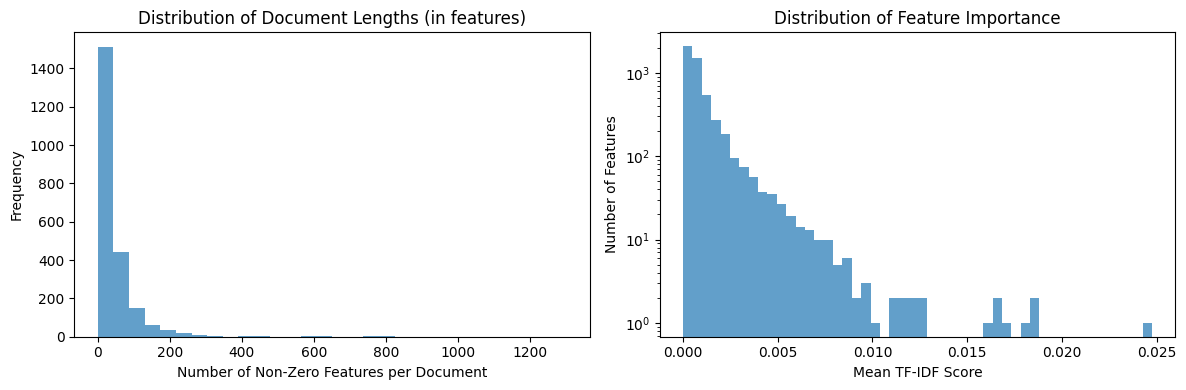

In [6]:
# Analyze the sparsity and distribution of our high-dimensional data
sparsity = (X_dense == 0).sum() / X_dense.size
print(f"Sparsity of the data: {sparsity:.4f} ({sparsity*100:.2f}% of values are zero)")

# Look at the distribution of non-zero values per document
non_zero_per_doc = (X_dense != 0).sum(axis=1)
print(f"Average non-zero features per document: {non_zero_per_doc.mean():.1f}")
print(f"Max non-zero features in a document: {non_zero_per_doc.max()}")
print(f"Min non-zero features in a document: {non_zero_per_doc.min()}")

# Visualize the distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(non_zero_per_doc, bins=30, alpha=0.7)
plt.xlabel('Number of Non-Zero Features per Document')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths (in features)')

plt.subplot(1, 2, 2)
# Show the mean TF-IDF score for each feature across all documents
feature_means = X_dense.mean(axis=0)
plt.hist(feature_means[feature_means > 0], bins=50, alpha=0.7)
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Importance')
plt.yscale('log')  # Log scale because most features have very low scores

plt.tight_layout()
plt.show()

In [7]:
# Standardize the features
print("Standardizing the high-dimensional data...")
start_time = time()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

print(f"Standardization completed in {time() - start_time:.2f} seconds")
print(f"Shape after standardization: {X_scaled.shape}")

# Check that standardization worked
print(f"Mean of first feature before standardization: {X_dense[:, 0].mean():.6f}")
print(f"Mean of first feature after standardization: {X_scaled[:, 0].mean():.6f}")
print(f"Std of first feature before standardization: {X_dense[:, 0].std():.6f}")
print(f"Std of first feature after standardization: {X_scaled[:, 0].std():.6f}")

Standardizing the high-dimensional data...
Standardization completed in 0.41 seconds
Shape after standardization: (2257, 5000)
Mean of first feature before standardization: 0.001411
Mean of first feature after standardization: -0.000000
Std of first feature before standardization: 0.016545
Std of first feature after standardization: 1.000000


In [8]:
# First, let's see how much variance the top components capture
print("Fitting PCA to analyze variance distribution...")
start_time = time()

# Fit PCA with all components to see the full variance breakdown
pca_full = PCA()
pca_full.fit(X_scaled)

print(f"PCA fitting completed in {time() - start_time:.2f} seconds")

# Analyze explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Show variance captured by first several components
print("Variance explained by first 20 components:")
for i in range(20):
    print(f"PC{i+1:2d}: {explained_variance_ratio[i]:.6f} ({explained_variance_ratio[i]*100:.3f}%) - "
          f"Cumulative: {cumulative_variance[i]:.6f} ({cumulative_variance[i]*100:.2f}%)")

# Find how many components needed for different variance thresholds
thresholds = [0.50, 0.80, 0.90, 0.95, 0.99]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

Fitting PCA to analyze variance distribution...
PCA fitting completed in 29.09 seconds
Variance explained by first 20 components:
PC 1: 0.004782 (0.478%) - Cumulative: 0.004782 (0.48%)
PC 2: 0.003797 (0.380%) - Cumulative: 0.008579 (0.86%)
PC 3: 0.003493 (0.349%) - Cumulative: 0.012072 (1.21%)
PC 4: 0.002857 (0.286%) - Cumulative: 0.014930 (1.49%)
PC 5: 0.002748 (0.275%) - Cumulative: 0.017677 (1.77%)
PC 6: 0.002632 (0.263%) - Cumulative: 0.020309 (2.03%)
PC 7: 0.002550 (0.255%) - Cumulative: 0.022859 (2.29%)
PC 8: 0.002521 (0.252%) - Cumulative: 0.025380 (2.54%)
PC 9: 0.002374 (0.237%) - Cumulative: 0.027754 (2.78%)
PC10: 0.002213 (0.221%) - Cumulative: 0.029967 (3.00%)
PC11: 0.002172 (0.217%) - Cumulative: 0.032139 (3.21%)
PC12: 0.002059 (0.206%) - Cumulative: 0.034198 (3.42%)
PC13: 0.002021 (0.202%) - Cumulative: 0.036219 (3.62%)
PC14: 0.001962 (0.196%) - Cumulative: 0.038181 (3.82%)
PC15: 0.001951 (0.195%) - Cumulative: 0.040132 (4.01%)
PC16: 0.001909 (0.191%) - Cumulative: 0.04204

<ipython-input-9-089e6fd02924>:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


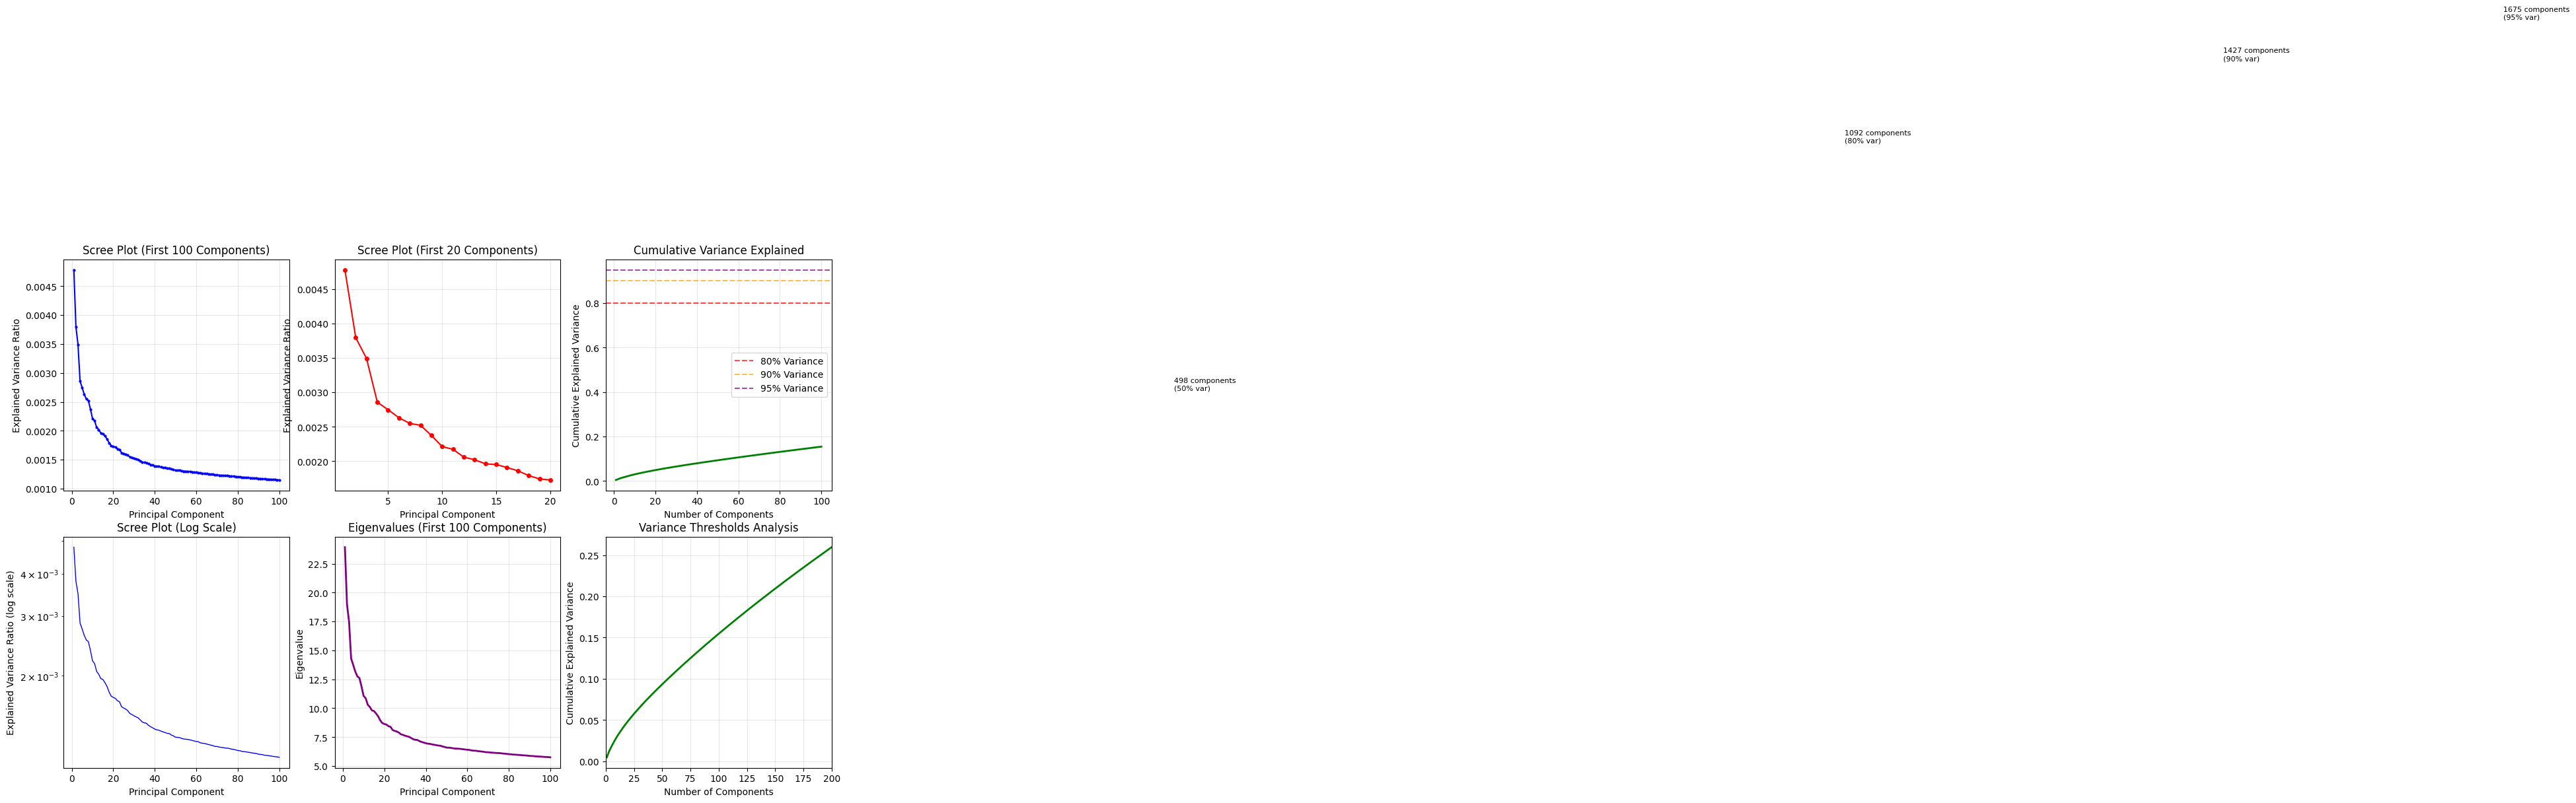

In [9]:
# Create comprehensive scree plots for high-dimensional data
plt.figure(figsize=(15, 10))

# Main scree plot - showing first 100 components
plt.subplot(2, 3, 1)
components_to_show = min(100, len(explained_variance_ratio))
plt.plot(range(1, components_to_show + 1), explained_variance_ratio[:components_to_show], 'b-o', markersize=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (First 100 Components)')
plt.grid(True, alpha=0.3)

# Zoomed scree plot - first 20 components
plt.subplot(2, 3, 2)
plt.plot(range(1, 21), explained_variance_ratio[:20], 'r-o', markersize=4)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (First 20 Components)')
plt.grid(True, alpha=0.3)

# Cumulative variance plot
plt.subplot(2, 3, 3)
plt.plot(range(1, components_to_show + 1), cumulative_variance[:components_to_show], 'g-', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% Variance')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Variance')
plt.axhline(y=0.95, color='purple', linestyle='--', alpha=0.7, label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

# Log scale scree plot to see the tail better
plt.subplot(2, 3, 4)
plt.plot(range(1, components_to_show + 1), explained_variance_ratio[:components_to_show], 'b-', linewidth=1)
plt.yscale('log')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio (log scale)')
plt.title('Scree Plot (Log Scale)')
plt.grid(True, alpha=0.3)

# Eigenvalue plot (same data, different perspective)
plt.subplot(2, 3, 5)
eigenvalues = pca_full.explained_variance_[:components_to_show]
plt.plot(range(1, components_to_show + 1), eigenvalues, 'purple', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues (First 100 Components)')
plt.grid(True, alpha=0.3)

# Component analysis - showing where different variance thresholds are reached
plt.subplot(2, 3, 6)
threshold_points = []
for threshold in [0.5, 0.8, 0.9, 0.95]:
    n_comp = np.argmax(cumulative_variance >= threshold) + 1
    threshold_points.append((n_comp, threshold))
    plt.axvline(x=n_comp, color='red', linestyle='--', alpha=0.5)
    plt.text(n_comp + 5, threshold - 0.05, f'{n_comp} components\n({threshold*100:.0f}% var)',
             fontsize=8, ha='left')

plt.plot(range(1, 201), cumulative_variance[:200], 'g-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Thresholds Analysis')
plt.grid(True, alpha=0.3)
plt.xlim(0, 200)

plt.tight_layout()
plt.show()

In [10]:
# Based on our analysis, let's choose the number of components
# Let's aim for 95% variance retention
target_variance = 0.95
optimal_components = np.argmax(cumulative_variance >= target_variance) + 1

print(f"Target variance retention: {target_variance*100:.0f}%")
print(f"Optimal number of components: {optimal_components}")
print(f"Actual variance retained: {cumulative_variance[optimal_components-1]*100:.2f}%")
print(f"Dimensionality reduction: {X_scaled.shape[1]} → {optimal_components}")
print(f"Reduction ratio: {optimal_components/X_scaled.shape[1]*100:.1f}% of original dimensions")

# Apply PCA with the chosen number of components
print(f"\nApplying PCA with {optimal_components} components...")
start_time = time()

pca_reduced = PCA(n_components=optimal_components)
X_pca = pca_reduced.fit_transform(X_scaled)

print(f"PCA transformation completed in {time() - start_time:.2f} seconds")
print(f"Original data shape: {X_scaled.shape}")
print(f"Reduced data shape: {X_pca.shape}")
print(f"Variance explained by chosen components: {pca_reduced.explained_variance_ratio_.sum():.4f}")

Target variance retention: 95%
Optimal number of components: 1675
Actual variance retained: 95.01%
Dimensionality reduction: 5000 → 1675
Reduction ratio: 33.5% of original dimensions

Applying PCA with 1675 components...
PCA transformation completed in 66.98 seconds
Original data shape: (2257, 5000)
Reduced data shape: (2257, 1675)
Variance explained by chosen components: 0.9483


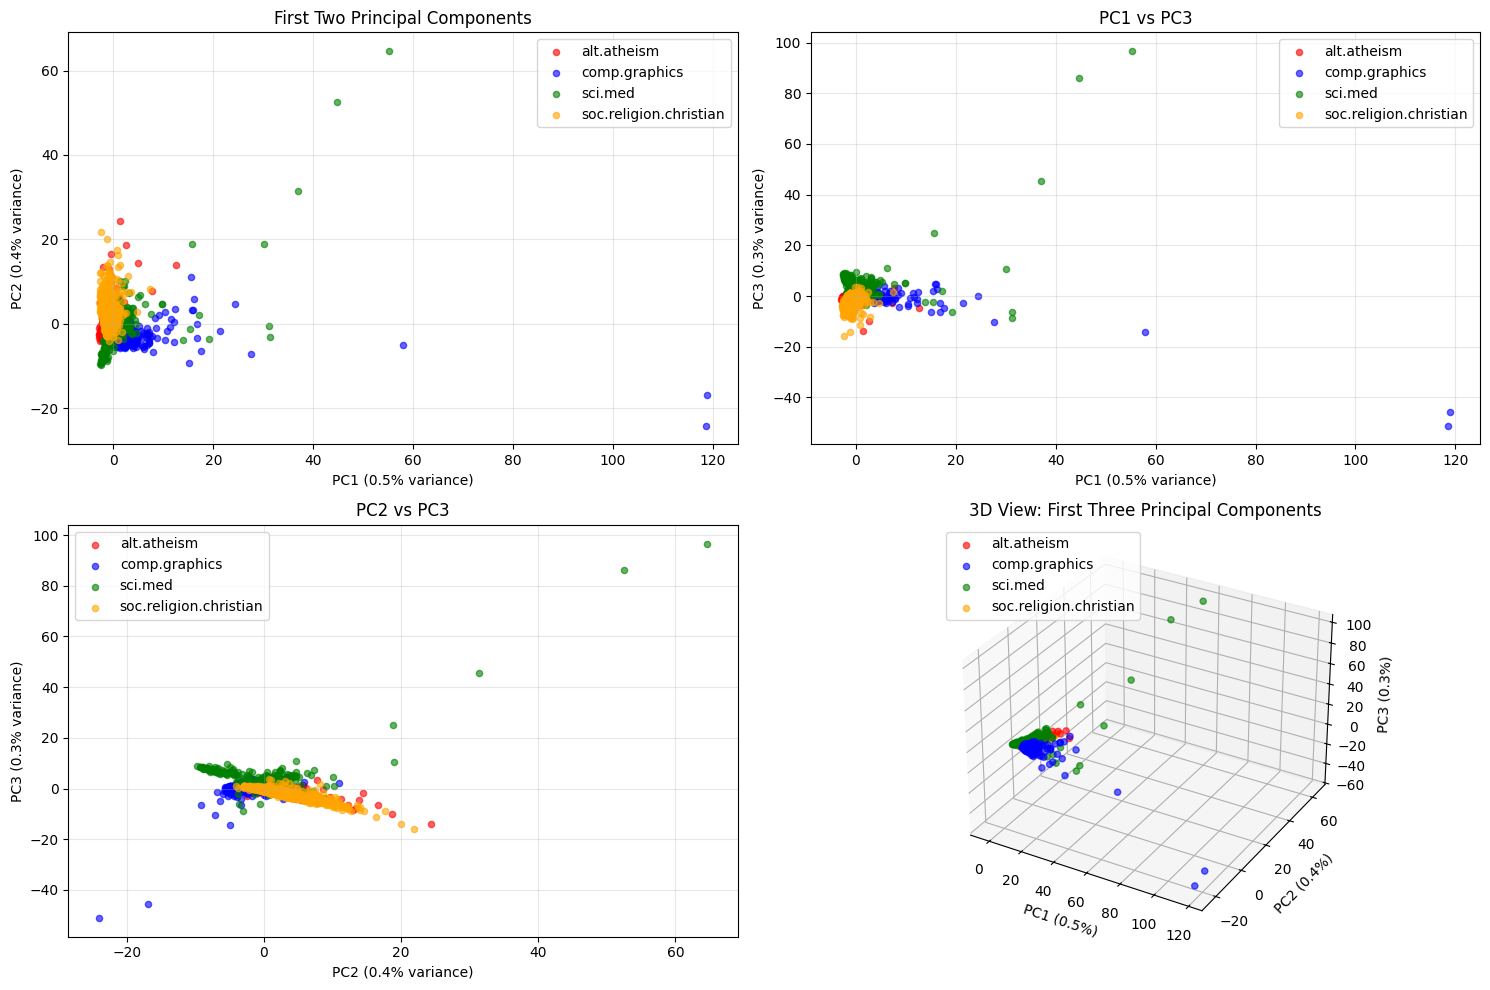

In [11]:
# Visualize the results in the first few principal components
plt.figure(figsize=(15, 10))

# Create color map for our categories
colors = ['red', 'blue', 'green', 'orange']
category_names = newsgroups_train.target_names

# Plot first two principal components
plt.subplot(2, 2, 1)
for i, category in enumerate(category_names):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[i], label=category, alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca_reduced.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_reduced.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('First Two Principal Components')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot first and third principal components
plt.subplot(2, 2, 2)
for i, category in enumerate(category_names):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 2], c=colors[i], label=category, alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca_reduced.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC3 ({pca_reduced.explained_variance_ratio_[2]*100:.1f}% variance)')
plt.title('PC1 vs PC3')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot second and third principal components
plt.subplot(2, 2, 3)
for i, category in enumerate(category_names):
    mask = y == i
    plt.scatter(X_pca[mask, 1], X_pca[mask, 2], c=colors[i], label=category, alpha=0.6, s=20)
plt.xlabel(f'PC2 ({pca_reduced.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.ylabel(f'PC3 ({pca_reduced.explained_variance_ratio_[2]*100:.1f}% variance)')
plt.title('PC2 vs PC3')
plt.legend()
plt.grid(True, alpha=0.3)

# Create a 3D plot of the first three components
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(2, 2, 4, projection='3d')
for i, category in enumerate(category_names):
    mask = y == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
              c=colors[i], label=category, alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_reduced.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_reduced.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca_reduced.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('3D View: First Three Principal Components')
ax.legend()

plt.tight_layout()
plt.show()

In [12]:
# Compare computational and storage requirements
original_size = X_scaled.size * 8  # 8 bytes per float64
reduced_size = X_pca.size * 8
compression_ratio = reduced_size / original_size

print("=== DIMENSIONALITY REDUCTION ANALYSIS ===")
print(f"Original dimensions: {X_scaled.shape[1]:,}")
print(f"Reduced dimensions: {X_pca.shape[1]:,}")
print(f"Reduction ratio: {X_pca.shape[1]/X_scaled.shape[1]*100:.1f}%")
print(f"Variance preserved: {pca_reduced.explained_variance_ratio_.sum()*100:.2f}%")
print()
print("=== COMPUTATIONAL IMPACT ===")
print(f"Original data size: {original_size/1024/1024:.1f} MB")
print(f"Reduced data size: {reduced_size/1024/1024:.1f} MB")
print(f"Storage compression: {compression_ratio*100:.1f}% of original size")
print()
print("=== PRACTICAL IMPLICATIONS ===")
print(f"• Training time reduction: ~{(1-compression_ratio)*100:.0f}% faster for most algorithms")
print(f"• Memory usage reduction: {(1-compression_ratio)*100:.0f}% less RAM required")
print(f"• Overfitting risk: Significantly reduced due to fewer parameters")
print(f"• Visualization: Now possible in 2D/3D space")

# Show the top words associated with first few principal components
print("\n=== INTERPRETATION OF PRINCIPAL COMPONENTS ===")
# Get the components (loadings) for interpretation
components = pca_reduced.components_

for i in range(min(3, len(components))):
    print(f"\nPrincipal Component {i+1} (explains {pca_reduced.explained_variance_ratio_[i]*100:.1f}% variance):")

    # Find words with highest positive and negative loadings
    component_loadings = components[i]
    top_positive_idx = np.argsort(component_loadings)[-10:][::-1]
    top_negative_idx = np.argsort(component_loadings)[:10]

    print("Most positively associated words:")
    for idx in top_positive_idx:
        print(f"  {feature_names[idx]}: {component_loadings[idx]:.3f}")

    print("Most negatively associated words:")
    for idx in top_negative_idx:
        print(f"  {feature_names[idx]}: {component_loadings[idx]:.3f}")

=== DIMENSIONALITY REDUCTION ANALYSIS ===
Original dimensions: 5,000
Reduced dimensions: 1,675
Reduction ratio: 33.5%
Variance preserved: 94.83%

=== COMPUTATIONAL IMPACT ===
Original data size: 86.1 MB
Reduced data size: 28.8 MB
Storage compression: 33.5% of original size

=== PRACTICAL IMPLICATIONS ===
• Training time reduction: ~66% faster for most algorithms
• Memory usage reduction: 66% less RAM required
• Overfitting risk: Significantly reduced due to fewer parameters
• Visualization: Now possible in 2D/3D space

=== INTERPRETATION OF PRINCIPAL COMPONENTS ===

Principal Component 1 (explains 0.5% variance):
Most positively associated words:
  144: 0.158
  129: 0.150
  lbl: 0.147
  umn: 0.143
  604: 0.143
  datasets: 0.138
  gis: 0.134
  spd: 0.128
  132: 0.125
  avs: 0.124
Most negatively associated words:
  god: -0.021
  believe: -0.016
  say: -0.015
  think: -0.014
  people: -0.014
  christians: -0.013
  surrender: -0.013
  cadre: -0.013
  shameful: -0.013
  dsl: -0.013

Princi